# 07MIAR_Proyecto_Programación - 03 CNN Resnet50

## 0. Librerías

In [2]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import json
from skimage.io import imread, imshow
from skimage.color import rgb2hsv
from keras.applications import InceptionV3, ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

## 1. Lectura de datos

### 1.1 Conexión remota con Google Drive

In [3]:
# Conexión remota con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.2. Establecer ruta directa al directorio y lectura de datos

In [4]:
# Establecimiento de una ruta absoluta al directorio de Google Drive
BASE_FOLDER = "/content/drive/MyDrive/BASE_FOLDER/"
DATASET = BASE_FOLDER + "my_dataset/ohe_data_train_resize_224.h5"

In [5]:
# Lectura del dataset
df = pd.read_hdf(DATASET,key='data')

## 2. Red Neuronal Convolucional ResNet50

### 2.1. Función para crear la red neuronal

In [6]:
# Función para crear la red neuronal
def make_model():
  modelResNet50=ResNet50(
      include_top=True,
      weights="imagenet",
      input_tensor=None,
      input_shape=None,
      pooling=None,
      classes=1000,
      classifier_activation="softmax",
  )

  num_capas = len(modelResNet50.layers)

  for capa in modelResNet50.layers:
      capa.trainable = False

  for capa in modelResNet50.layers[-5:]:
      capa.trainable = True

  model = Sequential([
      modelResNet50,
      Dense(512, activation='relu'),
      Dropout(0.5),
      Dense(256, activation='relu'),
      Dropout(0.5),
      Dense(12, activation='softmax')
  ])

  return model

### 2.2. Análisis de la red neuronal

In [7]:
# Guardar el modelo en una variable
model = make_model()

# Visualización de las capas de la red neuronal
model.summary()

102967424/102967424 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 12)                3084      
                                                       

## 3. Preprocesado de datos

In [8]:
# 'X' contiene las imágenes e 'y' contiene las etiquetas de las imágenes
X = np.array(df['imagen'].tolist())   # Convertir X a un arreglo NumPy
y = df.iloc[:, 1:]    # Selecciona todas las columnas excepto la primera (X)

# Dividir los datos en conjuntos de entrenamiento y prueba en un 20% del total y con una semilla de aleatoriedad constante
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Análisis de las dimensiones de los datos y etiquetas
print("Dimensiones de 'X_train':", X_train.shape)
print("Dimensiones de 'X_test':", X_test.shape)
print("Dimensiones de 'y_train':", y_train.shape)
print("Dimensiones de 'y_test':", y_test.shape)

Dimensiones de 'X_train': (3800, 224, 224, 3)
Dimensiones de 'X_test': (950, 224, 224, 3)
Dimensiones de 'y_train': (3800, 12)
Dimensiones de 'y_test': (950, 12)


### 3.1. Data augmentation

In [9]:
# Aplicación de 'data augmentation' para evitar 'overfitting'
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

# Preparar el generador de datos para el conjunto de entrenamiento
train_generator = datagen.flow(X_train, y_train)
test_generator = datagen.flow(X_test, y_test)

## 4. Hiperparámetros y entrenamiento de la red neuronal

### 4.1. Hiperparámetros

In [10]:
# Hiperparámetros
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 0.01 * 0.9**x)   # Reduce el learning rate según avanza el entrenamiento por cada época
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)   # Detiene el entrenamiento cuando se haya repetido el val_accuracy un número determinado de veces durante el entrenamiento (evita el overfitting)
epochs = 50   # Número de épocas
validation_split = 0.2    # Partición de los datos para validación
batch_size = 64   # Tamaño del lote de entrenamiento

### 4.2. Entrenamiento del modelo

In [11]:
# Entrenamiento
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("[INFO] Entrenando Red Neuronal...")
history = model.fit(X_train, y_train, epochs=epochs, callbacks=[reduce_lr, early_stop],
                    validation_split=validation_split, batch_size=batch_size)

[INFO] Entrenando Red Neuronal...
Epoch 1/50
48/48 [==============================] - 20s 179ms/step - loss: 1.8254 - accuracy: 0.3914 - val_loss: 1.5357 - val_accuracy: 0.4408 - lr: 0.0100
Epoch 2/50
48/48 [==============================] - 4s 93ms/step - loss: 1.4093 - accuracy: 0.5168 - val_loss: 1.3199 - val_accuracy: 0.4803 - lr: 0.0090
Epoch 3/50
48/48 [==============================] - 4s 82ms/step - loss: 1.3031 - accuracy: 0.5342 - val_loss: 1.3053 - val_accuracy: 0.4816 - lr: 0.0081
Epoch 4/50
48/48 [==============================] - 5s 100ms/step - loss: 1.1730 - accuracy: 0.5523 - val_loss: 1.2685 - val_accuracy: 0.5211 - lr: 0.0073
Epoch 5/50
48/48 [==============================] - 4s 82ms/step - loss: 1.1774 - accuracy: 0.5684 - val_loss: 1.2669 - val_accuracy: 0.5211 - lr: 0.0066
Epoch 6/50
48/48 [==============================] - 4s 83ms/step - loss: 1.1032 - accuracy: 0.5763 - val_loss: 1.1526 - val_accuracy: 0.5382 - lr: 0.0059
Epoch 7/50
48/48 [=====================

## 5. Evaluación del modelo

### 5.1. Análisis de 'test loss' y 'test accuracy'

In [12]:
# 'Test loss' y 'test accuracy'
print("[INFO] Evaluando Red Neuronal...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("\nTest accuracy:", test_acc)

[INFO] Evaluando Red Neuronal...
30/30 [==============================] - 2s 56ms/step - loss: 1.2227 - accuracy: 0.5611
Test loss: 1.2226674556732178

Test accuracy: 0.5610526204109192


### 5.2. Representación gráfica

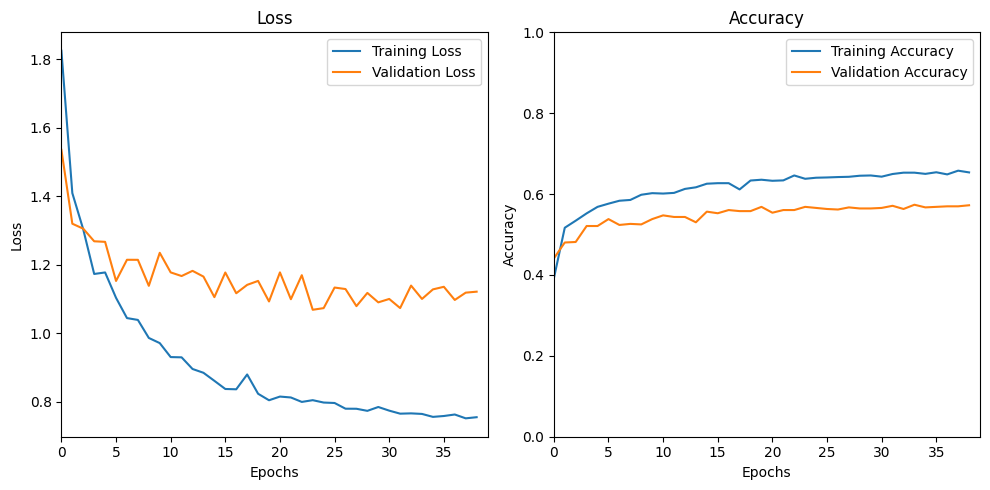

In [13]:
def plot_learning_curves(history):
    plt.figure(figsize=(10, 5))

    # Plot de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim(0, len(history.history['loss']))  # Establece límites para el eje x
    plt.legend()

    # Plot de precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Establece límites para el eje y
    plt.xlim(0, len(history.history['accuracy']))  # Establece límites para el eje x
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

### 5.3. Matriz de confusión

30/30 [==============================] - 2s 33ms/step


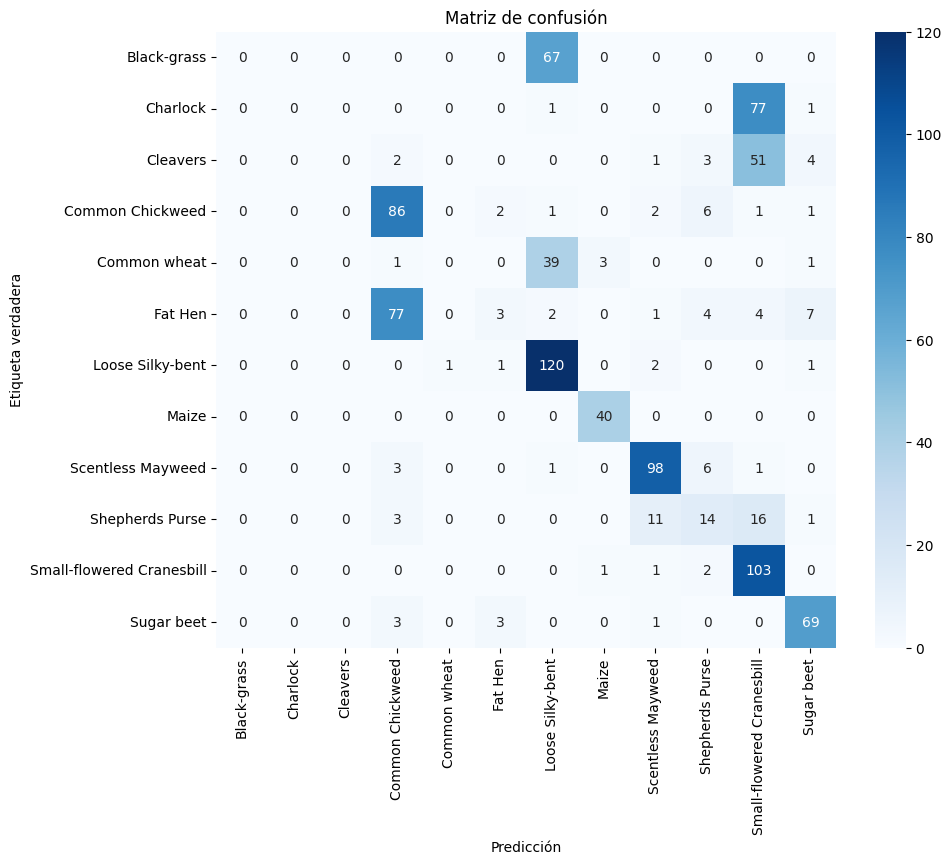

In [14]:
# Obtener predicciones del conjunto de prueba
Y_pred = model.predict(X_test)

# Convertir las predicciones de las clases en etiquetas
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = np.argmax(y_test.values, axis=1)

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
clases = [
    "Black-grass",
    "Charlock",
    "Cleavers",
    "Common Chickweed",
    "Common wheat",
    "Fat Hen",
    "Loose Silky-bent",
    "Maize",
    "Scentless Mayweed",
    "Shepherds Purse",
    "Small-flowered Cranesbill",
    "Sugar beet"
]
# Visualizar la matriz de confusión
def confusion_matrix_plot(confusion_mtx, clases):
  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
  plt.xlabel('Predicción')
  plt.ylabel('Etiqueta verdadera')
  plt.title('Matriz de confusión')
  plt.show()

confusion_matrix_plot(confusion_mtx=confusion_mtx, clases=clases)

## 6. Guardado del modelo

In [ ]:
# Guardado del modelo
model.save(BASE_FOLDER+"/models/resnet50/75/modelo_Resnet50_75.h5")